# Validation of Input Data

In [17]:
%matplotlib inline

import pandas as pd
import numpy as np

import seaborn as sns

## PECO: Interval

**Requirements**:  
1. For each HourlyUsage.[Premise, Year(UsageDate)], intersection of [CoincidentPeak] should equal 5
2. Coincident Peak Year [CoincidentPeak.CPYearId] is between Premise.[EffectiveStartDate, EffectiveStopDate]
3. Premise.[RateClass, Strata] not null. These values are used to select system and utility parameters

### Requirement \#1: Number of Coincident Peaks

In [7]:
from icap.database.icapdatabase import ICapDatabase
fp = 'icap/database/icapdatabase.json'

# connect to database
conn = ICapDatabase(fp).connect()

# verify connection
if (conn.__class__.__name__ != 'Connection'):
    raise Exception

To verify the correct number of coincicdent peaks:  
1. Intersection of [HourlyUsage] and [CoincidentPeak] on UtilityId and HourEnding
2. Count the number of usage values per (Premise, Year)

The full dataset is returned; allowing python to compute the relevant values

In [9]:
# return full dataset without aggregation
count_coincident_peaks = """
    select distinct
        h.PremiseId,
        Year(h.UsageDate) Year,
        count(h.Usage) as CPIntersection
    from [HourlyUsage] h
    inner join [CoincidentPeak] cp on
        cp.UtilityId = h.UtilityId and
        cp.CPDate = h.UsageDate and
        cp.HourEnding = h.HourEnding
    where
        h.UtilityId = 'PECO'
    group by
        h.PremiseId, Year(h.UsageDate)"""


premise_year_cp_count = pd.read_sql(count_coincident_peaks, conn)

In [107]:
# copy the data set
df = premise_year_cp_count.copy()

# create the crosstabulation
xtab_margins = pd.crosstab(df.CPIntersection, df.Year, margins=True)
xtab_bar = xtab_margins.ix[:-1, :-1];

#### Grouped Barchart

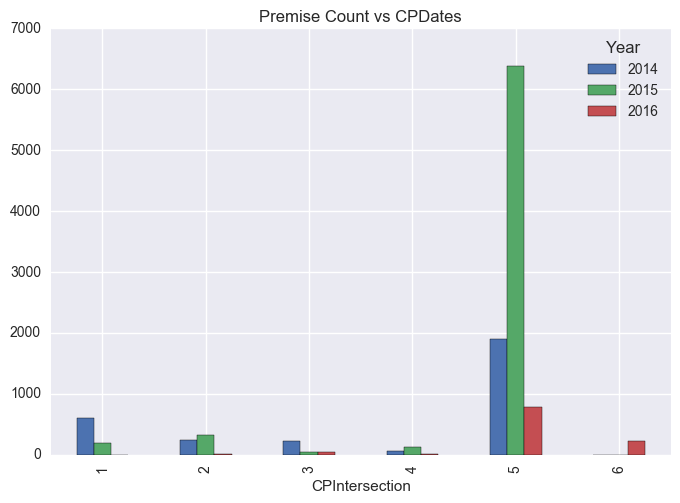

In [108]:
# grouped barchart
xtab_bar.plot.bar(title="Premise Count vs CPDates");

#### Crosstabulation of Valid vs Invalid Data

In [109]:
# valid and invalid percentage
total_count = xtab_margins.ix[-1, -1] 
valid_count = xtab_margins.ix[[5], -1]
invalid_count = np.sum(xtab_margins.ix[[1, 2, 3, 4, 6], -1])

valid_pct = valid_count / total_count
invalid_pct = invalid_count / total_count

print('*' * 79)
print('Total PECO Premises: %d' % total_count)
print('Total Valid Premises (5 CP Dates): %d' % valid_count)
print('Total Invalid Premises  (!5 CPDates): %d' % invalid_count)
print('Valid Percentage: %.3f' % valid_pct)
print('Invalid Percentage: %.3f' % invalid_pct)

# show xtab_margins
xtab_margins

*******************************************************************************
Total PECO Premises: 11111
Total Valid Premises (5 CP Dates): 9052
Total Invalid Premises  (!5 CPDates): 2059
Valid Percentage: 0.815
Invalid Percentage: 0.185


Year,2014,2015,2016,All
CPIntersection,,,,
1,603,183,0,786
2,242,314,6,562
3,215,36,44,295
4,57,121,14,192
5,1894,6377,781,9052
6,0,0,224,224
All,3011,7031,1069,11111


**Output**:  
Of the 11,111 total PECO hourly premises, 9052 (81.5%) satisfy the _Coincident Peak_ requirement. These premises will be extracted and passed through the next filter; _CPYearId between EffectiveStartDate and EffectiveStopDate_.

In [113]:
# extract the valid premises
cp_valid_premises = premise_year_cp_count[premise_year_cp_count.CPIntersection == 5]
cp_valid_premises.shape

(9052, 3)

In [117]:
# Number of unique premises
cp_valid_premises.PremiseId.drop_duplicates().shape

(6695,)

### Requirement (2, 3): CPYearId between EffectiveStartDate and EffectiveStopDate

Requirements (2, 3) will be tested concurrently. When filtering occurs for `NaN` values, those rows where `(RateClass, Strata)` contain `NaN` values will be removed.

In [127]:
# obtain the records
cond_2_query = """
    select distinct 
	p.PremiseId,
	p.RateClass,
	p.Strata,
	Year(cp.CPDate) Year
from [Premise] p
inner join [CoincidentPeak] cp on
	cp.UtilityId = p.UtilityId
where
	p.UtilityId = 'PECO' and
	cp.CPDate between p.EffectiveStartDate and p.EffectiveStopDate"""

effective_date = pd.read_sql(cond_2_query, conn)
df = effective_date.copy()

In [128]:
# How many rows? based on (premiseId, rateclass, strata, year)
df.shape

# Number of unique premises
df.PremiseId.drop_duplicates().shape

# Outer Join of `cp_valid_premises` and `effective_date`
full_outer = pd.merge(cp_valid_premises, effective_date, on=['PremiseId', 'Year'],
        how='outer').sort_values(by=['PremiseId', 'Year'])

In [159]:
full_outer.head(5)

,PremiseId,Year,CPIntersection,RateClass,Strata
23512,0004003025,2014,NaN,GS,101
20372,0004003025,2015,NaN,GS,101
7527,0006060055,2015,5.0,NaN,NaN
33754,0006060055,2013,NaN,HT,151
26809,0006060055,2014,NaN,HT,151


### Inspecting `full_outer`

In [133]:
full_outer.shape

(36390, 5)

After the `FULL OUTER JOIN` the table size increased to 36390. For these rows to be valid, each field within the row must be populated. Said another way, there can be no `NaN` values in the row.  

Dropping the values gives the following results.

In [164]:
orig_row_count = full_outer.shape[0]
valid_row_count = full_outer.dropna().shape[0]

valid_rows = full_outer.dropna()

print('Row count after FULL OUTER JOIN: %d' % orig_row_count)
print('Row count after all NaN values removed: %d' % valid_row_count)

Row count after FULL OUTER JOIN: 36390
Row count after all NaN values removed: 2768


In [177]:
# Pivot table describing total premises by (year, rateclass, strata)
piv = pd.pivot_table(valid_rows, index=['RateClass', 'Strata'], 
               columns=['Year'], 
               values='PremiseId', 
               aggfunc=len,
              margins=True)

piv['PctTotal'] = piv.ix[:, 'All'] / piv.iloc[-1, -1];


# Rateclass index
rateclass =piv.index.levels[0]

for rc in rateclass:
    num_premises, pct_total = piv.xs(rc)[['All', 'PctTotal']].sum()
    print('RateClass: %3s Number Premises: %6d Total Premise Percentage: %6.2f' % (rc, num_premises, pct_total))
    

RateClass: All Number Premises:   2768 Total Premise Percentage:   1.00
RateClass:  GS Number Premises:   2512 Total Premise Percentage:   0.91
RateClass:  HT Number Premises:    196 Total Premise Percentage:   0.07
RateClass:  PD Number Premises:     32 Total Premise Percentage:   0.01
RateClass:   R Number Premises:     25 Total Premise Percentage:   0.01
RateClass:  RH Number Premises:      3 Total Premise Percentage:   0.00


In [178]:
piv

Year               2014    2015   2016     All  PctTotal
RateClass Strata                                        
GS        101     170.0  1265.0  506.0  1941.0  0.701228
          107     205.0   260.0  106.0   571.0  0.206286
HT        151      70.0    84.0   42.0   196.0  0.070809
PD        157       3.0    24.0    5.0    32.0  0.011561
R         111       1.0     1.0    8.0    10.0  0.003613
          112       NaN     NaN    5.0     5.0  0.001806
          113       NaN     1.0    9.0    10.0  0.003613
RH        121       NaN     NaN    2.0     2.0  0.000723
          123       NaN     NaN    1.0     1.0  0.000361
All               449.0  1635.0  684.0  2768.0  1.000000

What do these results indicate? RateClass(**GS**) composes the majority of total possible premises. _Assumming_ the filtered dataset is the archetype of the total dataset, the recipe should focus on **GS** ICap calculations.

The values for `CPIntersection` will be dropped from valid rows. The full Interval dataset can now be retrieved and filtered against the available values.

In [181]:
premises_for_icap = valid_rows.drop('CPIntersection', axis=1).copy()

In [183]:
premises_for_icap.shape

(2768, 4)

### Computing the ICap

In [184]:
from icap.peco.peco import PECOInterval

In [185]:
p = PECOInterval(conn)

In [186]:
res = p.compute_icap()

In [188]:
pd.merge(res)

(9118, 9)

In [189]:
res.columns

Index(['RunDate', 'ISO', 'Utility', 'PremiseId', 'Year', 'RateClass', 'Strata',
       'MeterType', 'ICap'],
      dtype='object')

In [205]:
premises_for_icap['Year'] = premises_for_icap['Year'].apply(lambda x: str(x + 1))

In [207]:
merged = pd.merge(res, premises_for_icap,
        on=['PremiseId', 'RateClass', 'Strata', 'Year']).copy()

In [211]:
merged.head(20)

,RunDate,ISO,Utility,PremiseId,Year,RateClass,Strata,MeterType,ICap
0,2017-02-23 12:57:19.779035,PJM,PECO,0041076064,2016,GS,101,INT,275.776843
1,2017-02-23 12:57:19.779035,PJM,PECO,0041076064,2017,GS,101,INT,NaN
2,2017-02-23 12:57:19.779035,PJM,PECO,0047201106,2016,HT,151,INT,372.678045
3,2017-02-23 12:57:19.779035,PJM,PECO,0093300707,2016,GS,107,INT,0.220620
4,2017-02-23 12:57:19.779035,PJM,PECO,0099300205,2017,GS,101,INT,109.374393
5,2017-02-23 12:57:19.779035,PJM,PECO,0102900309,2016,GS,107,INT,0.238270
6,2017-02-23 12:57:19.779035,PJM,PECO,0120800204,2016,GS,107,INT,0.686128
7,2017-02-23 12:57:19.779035,PJM,PECO,0131200207,2016,GS,107,INT,0.917779
8,2017-02-23 12:57:19.779035,PJM,PECO,0153156079,2017,GS,101,INT,13.821781
9,2017-02-23 12:57:19.779035,PJM,PECO,0192001576,2017,GS,101,INT,40.842497
